In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [134]:
with open('../data/vectors.pkl', 'rb') as f:
    data = pickle.load(f)

In [135]:
with open('../data/labels.pkl', 'rb') as f:
    labels = pickle.load(f)

In [136]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [137]:
train_data, test_val_data, train_labels, test_val_labels = train_test_split(data, labels, train_size=0.7, random_state=42, shuffle=True, stratify=labels)
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data, test_val_labels, test_size=0.5, random_state=42, shuffle=True, stratify=test_val_labels)

In [138]:
train_data_tensor = torch.from_numpy(train_data)
val_data_tensor = torch.from_numpy(val_data)
test_data_tensor = torch.from_numpy(test_data)
train_labels_tensor = torch.from_numpy(train_labels)
val_labels_tensor = torch.from_numpy(val_labels)
test_labels_tensor = torch.from_numpy(test_labels)

In [139]:
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [140]:
class DenseNet(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 3)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.act(out)
        out = self.fc2(out)
        out = self.act(out)
        out = self.fc3(out)
        out = self.act(out)
        out = self.fc4(out)
        out = self.act(out)
        out = self.fc5(out)
        
        return out

In [141]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [142]:
def training_loop(n_epochs, model, optimizer, criterion, train_loader, val_loader):
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        loss_train = 0.0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        
        avg_loss_train = loss_train / len(train_loader)
        train_losses.append(avg_loss_train)
        
        loss_val = 0.0
        with torch.no_grad():
            for val_data, val_labels in val_loader:
                val_data, val_labels = val_data.to(device), val_labels.to(device)
                val_outputs = model(val_data)
                loss_val += criterion(val_outputs, val_labels).item()
            avg_loss_val = loss_val / len(val_loader)
            val_losses.append(avg_loss_val)

        print('{} Epoch {}, Training loss: {:.4f}'.format(datetime.datetime.now(), epoch + 1, avg_loss_train))
        print('{} Epoch {}, Validation loss: {:.4f}'.format(datetime.datetime.now(), epoch + 1, avg_loss_val))

    return train_losses, val_losses

In [143]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [144]:
def evaluate_model(model, data_loader):
    loss = 0.0
    correct = 0.0
    total = 0.0
    
    model.eval()
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            loss += criterion(output, labels).item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = loss / len(data_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [145]:
n_epochs = 10
learning_rate = 0.0001

model = DenseNet(dropout=0.5)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [146]:
train_losses, val_losses = training_loop(n_epochs, model, optimizer, criterion, train_loader, val_loader)

2024-05-02 23:32:45.417064 Epoch 1, Training loss: 0.6609
2024-05-02 23:32:45.417178 Epoch 1, Validation loss: 0.5745
2024-05-02 23:32:46.899610 Epoch 2, Training loss: 0.5540
2024-05-02 23:32:46.899715 Epoch 2, Validation loss: 0.5584
2024-05-02 23:32:48.567524 Epoch 3, Training loss: 0.5377
2024-05-02 23:32:48.567628 Epoch 3, Validation loss: 0.5485
2024-05-02 23:32:50.101468 Epoch 4, Training loss: 0.5241
2024-05-02 23:32:50.101574 Epoch 4, Validation loss: 0.5399
2024-05-02 23:32:51.586173 Epoch 5, Training loss: 0.5112
2024-05-02 23:32:51.586278 Epoch 5, Validation loss: 0.5347
2024-05-02 23:32:53.056410 Epoch 6, Training loss: 0.4995
2024-05-02 23:32:53.056512 Epoch 6, Validation loss: 0.5315
2024-05-02 23:32:54.531988 Epoch 7, Training loss: 0.4885
2024-05-02 23:32:54.532121 Epoch 7, Validation loss: 0.5281
2024-05-02 23:32:56.020907 Epoch 8, Training loss: 0.4781
2024-05-02 23:32:56.021005 Epoch 8, Validation loss: 0.5324
2024-05-02 23:32:57.503023 Epoch 9, Training loss: 0.468

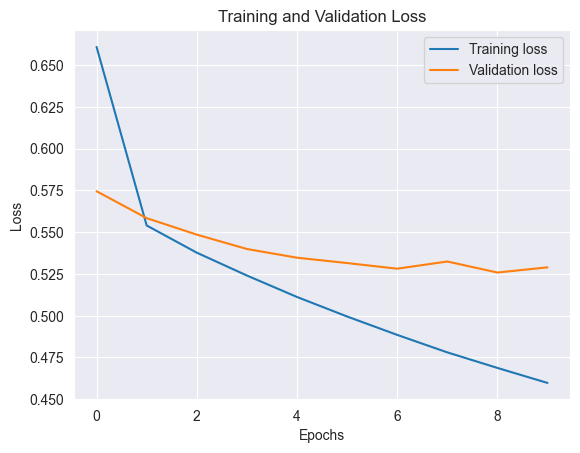

In [147]:
plot_losses(train_losses, val_losses)

In [148]:
evaluate_model(model, val_loader)

(0.5289427685002758, 79.0482308227611)

In [149]:
model.eval()
predictions = []
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        predictions.extend(outputs.tolist())

probs = torch.tensor(predictions)
predicted_classes = torch.argmax(probs, dim=1)

In [150]:
print(classification_report(predicted_classes, test_labels))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      7808
           1       0.84      0.78      0.81      6214
           2       0.68      0.73      0.70      4658

    accuracy                           0.79     18680
   macro avg       0.78      0.78      0.78     18680
weighted avg       0.79      0.79      0.79     18680



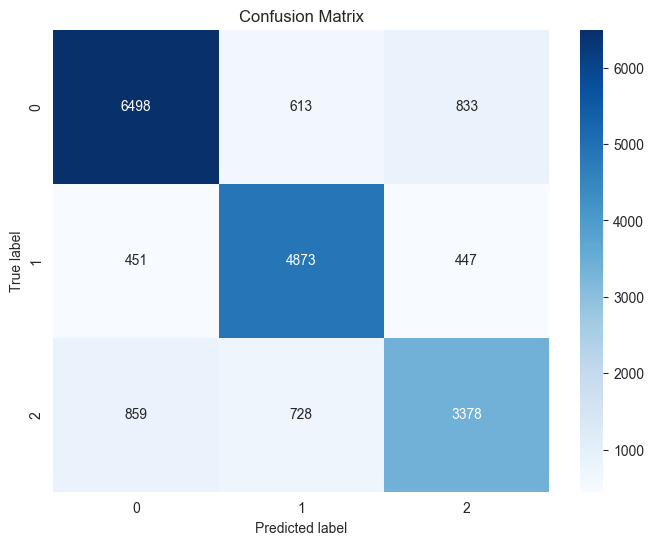

In [151]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()